In [1]:
import torch
import scGCRC_Utils as utils
from scGCRC_Model import CLNetwork
device = torch.device('cpu')

In [2]:
# Step1: reading dataset
dataset_name = 'Klein'
cell_matrix, cells, genes = utils.load_data('dataset/' + dataset_name + '/' + dataset_name + '_top2000.csv')
cell_labels, n_cluster = utils.load_label('dataset/' + dataset_name + '/label')

In [3]:
################## using saved model to validate the experimental results ###############
# Step2 (used saved model): get graph neibours and training 
pca_path = 'dataset/' + dataset_name + '/pca_data'
adjs4GAT_mask, adjs4CL = utils.generateNeibour(cell_matrix, pca_path=pca_path)

## loading saved model
X = torch.FloatTensor(utils.normalization(cell_matrix)).to(device)
model = CLNetwork(X.shape[-1], 256, 32, n_cluster, adjs4GAT_mask, 4)
model.load_state_dict(torch.load('dataset/' + dataset_name + '/' + dataset_name + '.pkl'))
model = model.to(device)

In [4]:
# # Step2 (training model) : get graph neibours and training 
# adjs4GAT_mask, adjs4CL = utils.generateNeibour(cell_matrix)

# ## training model
# X = torch.FloatTensor(utils.normalization(cell_matrix)).to(device)
# model = CLNetwork(X.shape[-1], 256, 32, n_cluster, adjs4GAT_mask, 4)
# model = utils.training(X, model, adjs4CL, device, cell_labels)

In [4]:
# Step4: predict
model.eval()
with torch.no_grad():
    _, hidden = model.forward_cluster(X)
    hidden = hidden.detach().cpu().numpy()

# Adjusting the resolution will result in different numbers of celltypes
predict = utils.LeidenClustering(hidden, resolution=0.01)
# or you can define a specific clusters
#predict = utils.ClusteringWithClusters(hidden, n_cluster=n_cluster)

In [5]:
# Step5: evaluation
print('nclusters:{}, predict clusters:{}'.format(n_cluster, len(set(predict))))
print('ARI: {:.3f}, NMI: {:.3f}'.format(utils.getARI(cell_labels, predict), utils.getNMI(cell_labels, predict)))

nclusters:4, predict clusters:4
ARI: 0.968, NMI: 0.950


In [6]:
################## Visualization ###############
import matplotlib.pyplot as plt
import matplotlib
import umap
import umap.plot

In [7]:
reducer = umap.UMAP()
X_tsne = reducer.fit_transform(hidden)

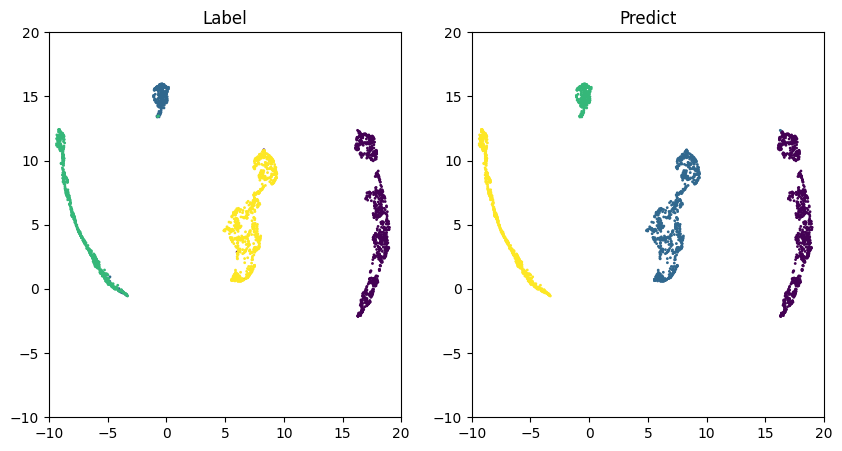

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
scatter=plt.scatter(X_tsne[:, 0], X_tsne[:, 1],  c=cell_labels, s=1)
plt.title('Label', fontsize=12)
plt.ylim(-10.0, 20.0)
plt.xlim(-10.0, 20.0)
    
plt.subplot(122)
scatter=plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=predict, s=1)
plt.title('Predict', fontsize=12)
plt.ylim(-10.0, 20.0)
plt.xlim(-10.0, 20.0)
plt.show()